In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
import numpy as np
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import geopandas
from geodatasets import get_path


In [2]:
os.chdir("..")


In [22]:
dataset = pd.read_csv("DATA_INDIA/CLEAN_MERGED/complete_dataset.csv")

In [23]:
dataset.columns

Index(['Unnamed: 0', 'State', 'City', 'City Population', 'State Population',
       'State Area (sq. km)', 'Forest Area(sq. km in state)',
       'Registered Vehicles in City', 'Registered Vehicles in State',
       'Farming Area (sq. km in state)', 'Farmers (in state)',
       'Factories (in state)',
       'Shipping Cargo Volume ( million metric tons in state)', 'Temperature',
       'Pressure', 'Humidity', 'Wind', 'Precipitation', 'Clouds', 'Sunshine',
       'Coal Capacity (Max Electricity ouput in MW)',
       'Gas Capacity (Max Electricity ouput in MW)', 'aqi', 'missing_aqi',
       'AQI Category'],
      dtype='object')

# State level analysis and visualization:

    Lasso plot can be nice because it is pretty advanced.

In [4]:
# Aggregating relevant state-level data
state_level_df = dataset.groupby('State').agg({
    'State Population': 'first',  # State population is the same for all cities in a state
    'State Area (sq. km)': 'first',
    'Forest Area(sq. km in state)': 'first',
    'Registered Vehicles in State': 'first',
    'Framing Area (sq. km in state)': 'first',
    'Farmers (in state)': 'first',
    'Factories (in state)': 'first',
    'Shipping Cargo Volume ( million metric tons in state)': 'first',
    'Coal Capacity (Max Electricity ouput in MW)': 'first',  
    'Gas Capacity (Max Electricity ouput in MW)': 'first',
    'Temperature': 'mean',  #average temperature across the cities
    'Pressure': 'mean',
    'Humidity': 'mean',
    'Wind': 'mean',
    'Precipitation': 'mean',
    'Clouds': 'mean',
    'Sunshine': 'mean',
    'aqi': 'mean',  # Average AQI across cities in the state
    'missing_aqi': 'mean'  # Average of missing AQI proportions
}).reset_index()

# Define AQI categories and corresponding labels
aqi_bins = [0, 50, 100, 200, 300, 400, 500]
aqi_labels = ["Good", "Satisfactory", "Moderate", "Poor", "Very Poor", "Severe"]

# Add the AQI_Category column with categorical data type
state_level_df['AQI Category'] = pd.cut(
    state_level_df['aqi'], 
    bins=aqi_bins, 
    labels=aqi_labels, 
    include_lowest=True
)

# Convert AQI_Category to a categorical data type with ordered categories
state_level_df['AQI Category'] = pd.Categorical(
    state_level_df['AQI Category'], 
    categories=aqi_labels, 
    ordered=True
)

display(state_level_df)

,State,State Population,State Area (sq. km),Forest Area(sq. km in state),Registered Vehicles in State,Framing Area (sq. km in state),Farmers (in state),Factories (in state),Shipping Cargo Volume ( million metric tons in state),Coal Capacity (Max Electricity ouput in MW),...,Temperature,Pressure,Humidity,Wind,Precipitation,Clouds,Sunshine,aqi,missing_aqi,AQI Category
0,andhra pradesh,53402000.0,162968.0,29784.00,13108491.0,351.3,16967754.0,0.0,175.18,11275.0,...,296.417500,1007.168750,72.797500,2.377500,0.010000,27.256250,124.145000,108.428128,0.173387,Moderate
1,arunachal pradesh,1580000.0,83743.0,66431.00,230126.0,35.4,36171.0,0.0,0.00,0.0,...,288.800000,1010.920000,71.550000,1.440000,0.020000,32.290000,95.080000,89.454545,0.290323,Satisfactory
2,assam,36159000.0,78438.0,28312.00,4358529.0,350.5,1845346.0,6425.0,0.00,0.0,...,289.832000,1011.984000,76.874000,1.446000,0.026000,31.846000,113.106000,189.857048,0.086022,Moderate
3,bihar,129205000.0,94163.0,7381.00,9903889.0,546.3,18345649.0,6345.0,0.00,10040.0,...,288.780000,1017.372500,70.069500,2.289500,0.175500,23.415500,181.650500,227.372241,0.102919,Poor
4,chandigarh,1247000.0,114.0,22.88,1058857.0,127.4,1687.0,423.0,0.00,0.0,...,285.460000,997.800000,68.140000,2.290000,0.040000,25.800000,190.380000,289.225806,0.000000,Poor
5,chhattisgarh,30638000.0,135192.0,55717.00,6986219.0,325.0,5091882.0,5103.0,0.00,17795.0,...,292.970000,1004.170000,61.200000,1.840000,0.010000,15.770000,199.000000,98.811884,0.084677,Satisfactory
6,delhi,21884000.0,1483.0,195.00,11892877.0,133.1,39475.0,0.0,0.00,0.0,...,286.200000,1015.520000,80.630000,2.320000,0.010000,29.830000,136.460000,354.838710,0.000000,Very Poor
7,gujarat,72653000.0,196244.0,14926.00,26836981.0,518.3,6839415.0,36727.0,553.92,15592.0,...,294.348000,1016.442000,59.446000,2.942000,0.000000,9.246000,243.786000,111.773422,0.170507,Moderate
8,haryana,30694000.0,44212.0,1603.00,8599668.0,823.3,1528133.0,13780.0,0.00,4065.0,...,286.307391,1011.050000,68.616522,2.375652,0.018696,23.917826,175.769130,177.193706,0.059140,Moderate
9,himachal pradesh,7518000.0,55673.0,15443.00,1711920.0,116.2,175038.0,5254.0,0.00,0.0,...,285.460000,997.800000,68.140000,2.290000,0.040000,25.800000,190.380000,298.766667,0.032258,Poor


In [5]:
state_level_df = state_level_df.dropna()

In [6]:
x_names = state_level_df.columns.tolist()

In [7]:
# We drop the Y variable as well as the name of the state and keep the rest.
drop = ["State","AQI Category","aqi"]
x_names = [name for name in x_names if name not in drop]
X = state_level_df[x_names]

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [11]:
y = state_level_df["aqi"]

In [12]:
lasso_model = Lasso(alpha=0.1)

In [13]:
lasso_model.fit(X,y)


Lasso(alpha=0.1)

In [14]:
def plot_lasso_r(X, y, max_penalty, norm_type='standard'):        
    rows = []

    for penalty in np.linspace(0, max_penalty, 20):
        if penalty == 0:
            ols = LinearRegression().fit(X, y)
            rows.append(ols.coef_.tolist() + [penalty])
        else:    
            lasso = Lasso(alpha=penalty).fit(X, y)
            rows.append(lasso.coef_.tolist() + [penalty])
    
    # Create a DataFrame from the list of coefficients and penalty values
    df_coefficients = pd.DataFrame(rows, columns=x_names + ['Lasso penalty term value'])
    df_coefficients.set_index('Lasso penalty term value', inplace=True)
    
    # Get the top 5 most significant coefficients based on their absolute mean value
    col_legend = df_coefficients.abs().mean().sort_values(ascending=False)[0:5].index.to_list()

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Plot the coefficient values for different penalties (alpha values)
    df_coefficients.plot(ax=ax, use_index=True, legend=False)

    # Create custom lines for the legend based on the selected columns (top 5 by mean absolute value)
    line_mapping = {col: line for col, line in zip(df_coefficients.columns, ax.get_lines())}
    columns_to_include = col_legend
    custom_lines = [line_mapping[col] for col in columns_to_include]
    ax.legend(custom_lines, columns_to_include)
    
    # Set the title of the plot
    plt.title(f"Coefficient values at different Lasso penalties (alpha) for AQI across states")
    
    # Show the plot
    plt.show()
    return df_coefficients.mean().sort_values(ascending=False)     

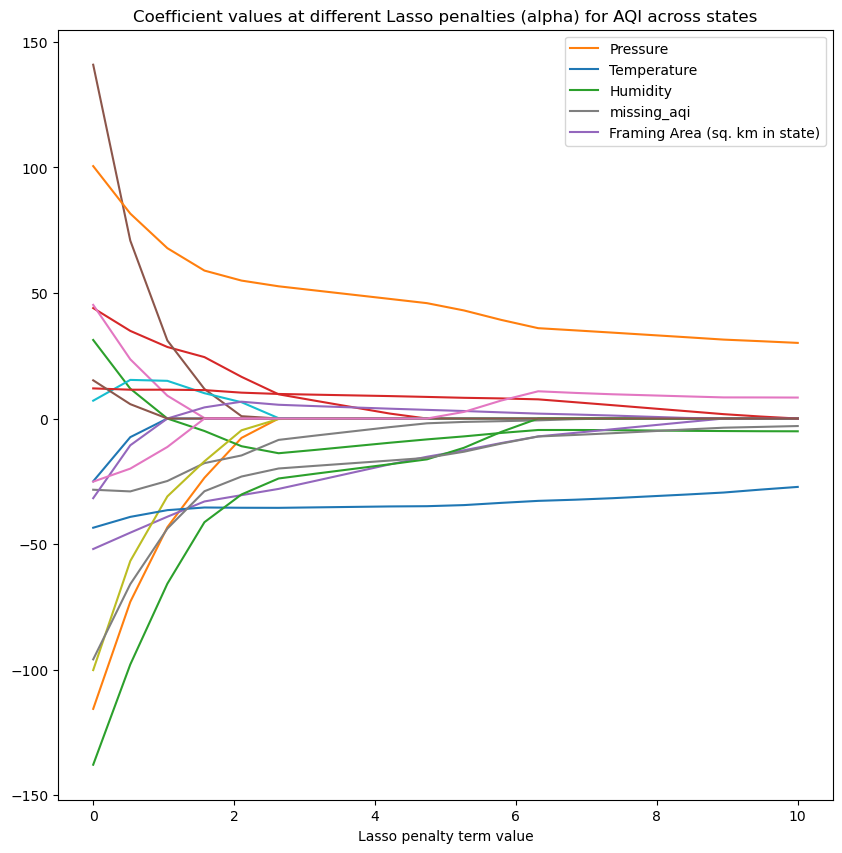

Pressure                                                 47.811524
Farmers (in state)                                       12.779475
Registered Vehicles in State                              8.584749
Wind                                                      7.401306
Factories (in state)                                      3.907186
Gas Capacity (Max Electricity ouput in MW)                2.712612
Sunshine                                                  1.368320
Clouds                                                    1.047818
Precipitation                                             0.108318
State Population                                         -1.620688
Forest Area(sq. km in state)                             -3.971866
Shipping Cargo Volume ( million metric tons in state)    -7.187820
Coal Capacity (Max Electricity ouput in MW)             -10.492397
State Area (sq. km)                                     -13.161770
Framing Area (sq. km in state)                          -17.58

In [15]:
plot_lasso_r(X,y,10)

# City analysis:

In [28]:
#state-level columns to drop
# Remove unnamed:0 for main code file it will not be needed.
cities_df = dataset.drop(columns=["Unnamed: 0","Registered Vehicles in City"])

In [31]:
cities_df = cities_df.dropna(subset=["City Population"])

In [32]:
# When we drop cities with missing population values we see that only 6 weather observations are not there.
# Hopefully these cities are missing because they are small and have low aqi. Then we can claim.
na_counts = cities_df.isna().sum()
print(na_counts)

State                                                    0
City                                                     0
City Population                                          0
State Population                                         0
State Area (sq. km)                                      0
Forest Area(sq. km in state)                             0
Registered Vehicles in State                             0
Farming Area (sq. km in state)                           0
Farmers (in state)                                       0
Factories (in state)                                     0
Shipping Cargo Volume ( million metric tons in state)    0
Temperature                                              0
Pressure                                                 0
Humidity                                                 0
Wind                                                     0
Precipitation                                            0
Clouds                                                  

In [33]:
cities_df["fact"]

,State,City,City Population,State Population,State Area (sq. km),Forest Area(sq. km in state),Registered Vehicles in State,Farming Area (sq. km in state),Farmers (in state),Factories (in state),...,Humidity,Wind,Precipitation,Clouds,Sunshine,Coal Capacity (Max Electricity ouput in MW),Gas Capacity (Max Electricity ouput in MW),aqi,missing_aqi,AQI Category
0,uttar pradesh,agra,1430055.0,238875000.0,240928.0,14818.0,34924824.0,685.6,19939223.0,0.0,...,68.55,2.23,0.01,14.88,241.62,16608.0,1469.00,121.258065,0.000000,Moderate
1,gujarat,ahmedabad,3719710.0,72653000.0,196244.0,14926.0,26836981.0,518.3,6839415.0,36727.0,...,55.86,2.43,0.00,9.51,252.54,15592.0,7990.72,133.483871,0.000000,Moderate
2,mizoram,aizawl,265331.0,1252000.0,21081.0,17820.0,267350.0,71.0,41787.0,4.0,...,76.38,1.07,0.02,23.92,172.62,0.0,0.00,43.275862,0.064516,Good
3,rajasthan,ajmer,517911.0,82188000.0,342239.0,16655.0,19236010.0,537.4,4939664.0,12169.0,...,51.28,2.29,0.01,11.37,265.92,4955.0,856.80,111.774194,0.000000,Moderate
4,maharashtra,akola,428857.0,127684000.0,307713.0,50798.0,37786256.0,536.2,13486140.0,0.0,...,48.98,2.29,0.01,15.32,243.00,16750.0,3460.00,135.193548,0.000000,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,tamil nadu,vellore,177081.0,77165000.0,130060.0,26419.0,32094588.0,371.2,9606547.0,28200.0,...,74.45,2.29,0.02,36.89,127.38,12160.0,1013.49,93.230769,0.580645,Satisfactory
258,andhra pradesh,vijayawada,874587.0,53402000.0,162968.0,29784.0,13108491.0,351.3,16967754.0,0.0,...,74.81,1.93,0.01,26.18,105.77,11275.0,7508.20,76.333333,0.516129,Satisfactory
259,maharashtra,virar,150357.0,127684000.0,307713.0,50798.0,37786256.0,536.2,13486140.0,0.0,...,63.56,3.44,0.00,11.39,242.46,16750.0,3460.00,128.068966,0.064516,Moderate
261,andhra pradesh,visakhapatnam,1063178.0,53402000.0,162968.0,29784.0,13108491.0,351.3,16967754.0,0.0,...,76.74,2.59,0.00,23.01,135.15,11275.0,7508.20,193.607143,0.096774,Moderate


In [41]:
x_names = cities_df.columns.tolist()
x_names.remove("missing_aqi")
x_names.remove("aqi")
x_names.remove("AQI Category")
x_names.remove("City")
x_names.remove("State") # No state level fixed effects which is super sad :( There are states with only one city :(


In [42]:
X = cities_df[x_names]
y = cities_df["aqi"]


In [47]:
X.shape[0] -1

135

In [49]:
rf = RandomForestRegressor()

In [54]:
# Remember the scale is 0-500

scores = cross_val_score(rf, X, y,scoring='neg_root_mean_squared_error' ,cv=X.shape[0] -1)
np.mean(scores)

-45.08521653233995

Random forest plot of variable importance training on full data. This is not technically correct as it should be done on the
training set but whatever.

https://scikit-learn.org/1.6/auto_examples/ensemble/plot_forest_importances.html

In [55]:
forest = RandomForestRegressor()
forest.fit(X,y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

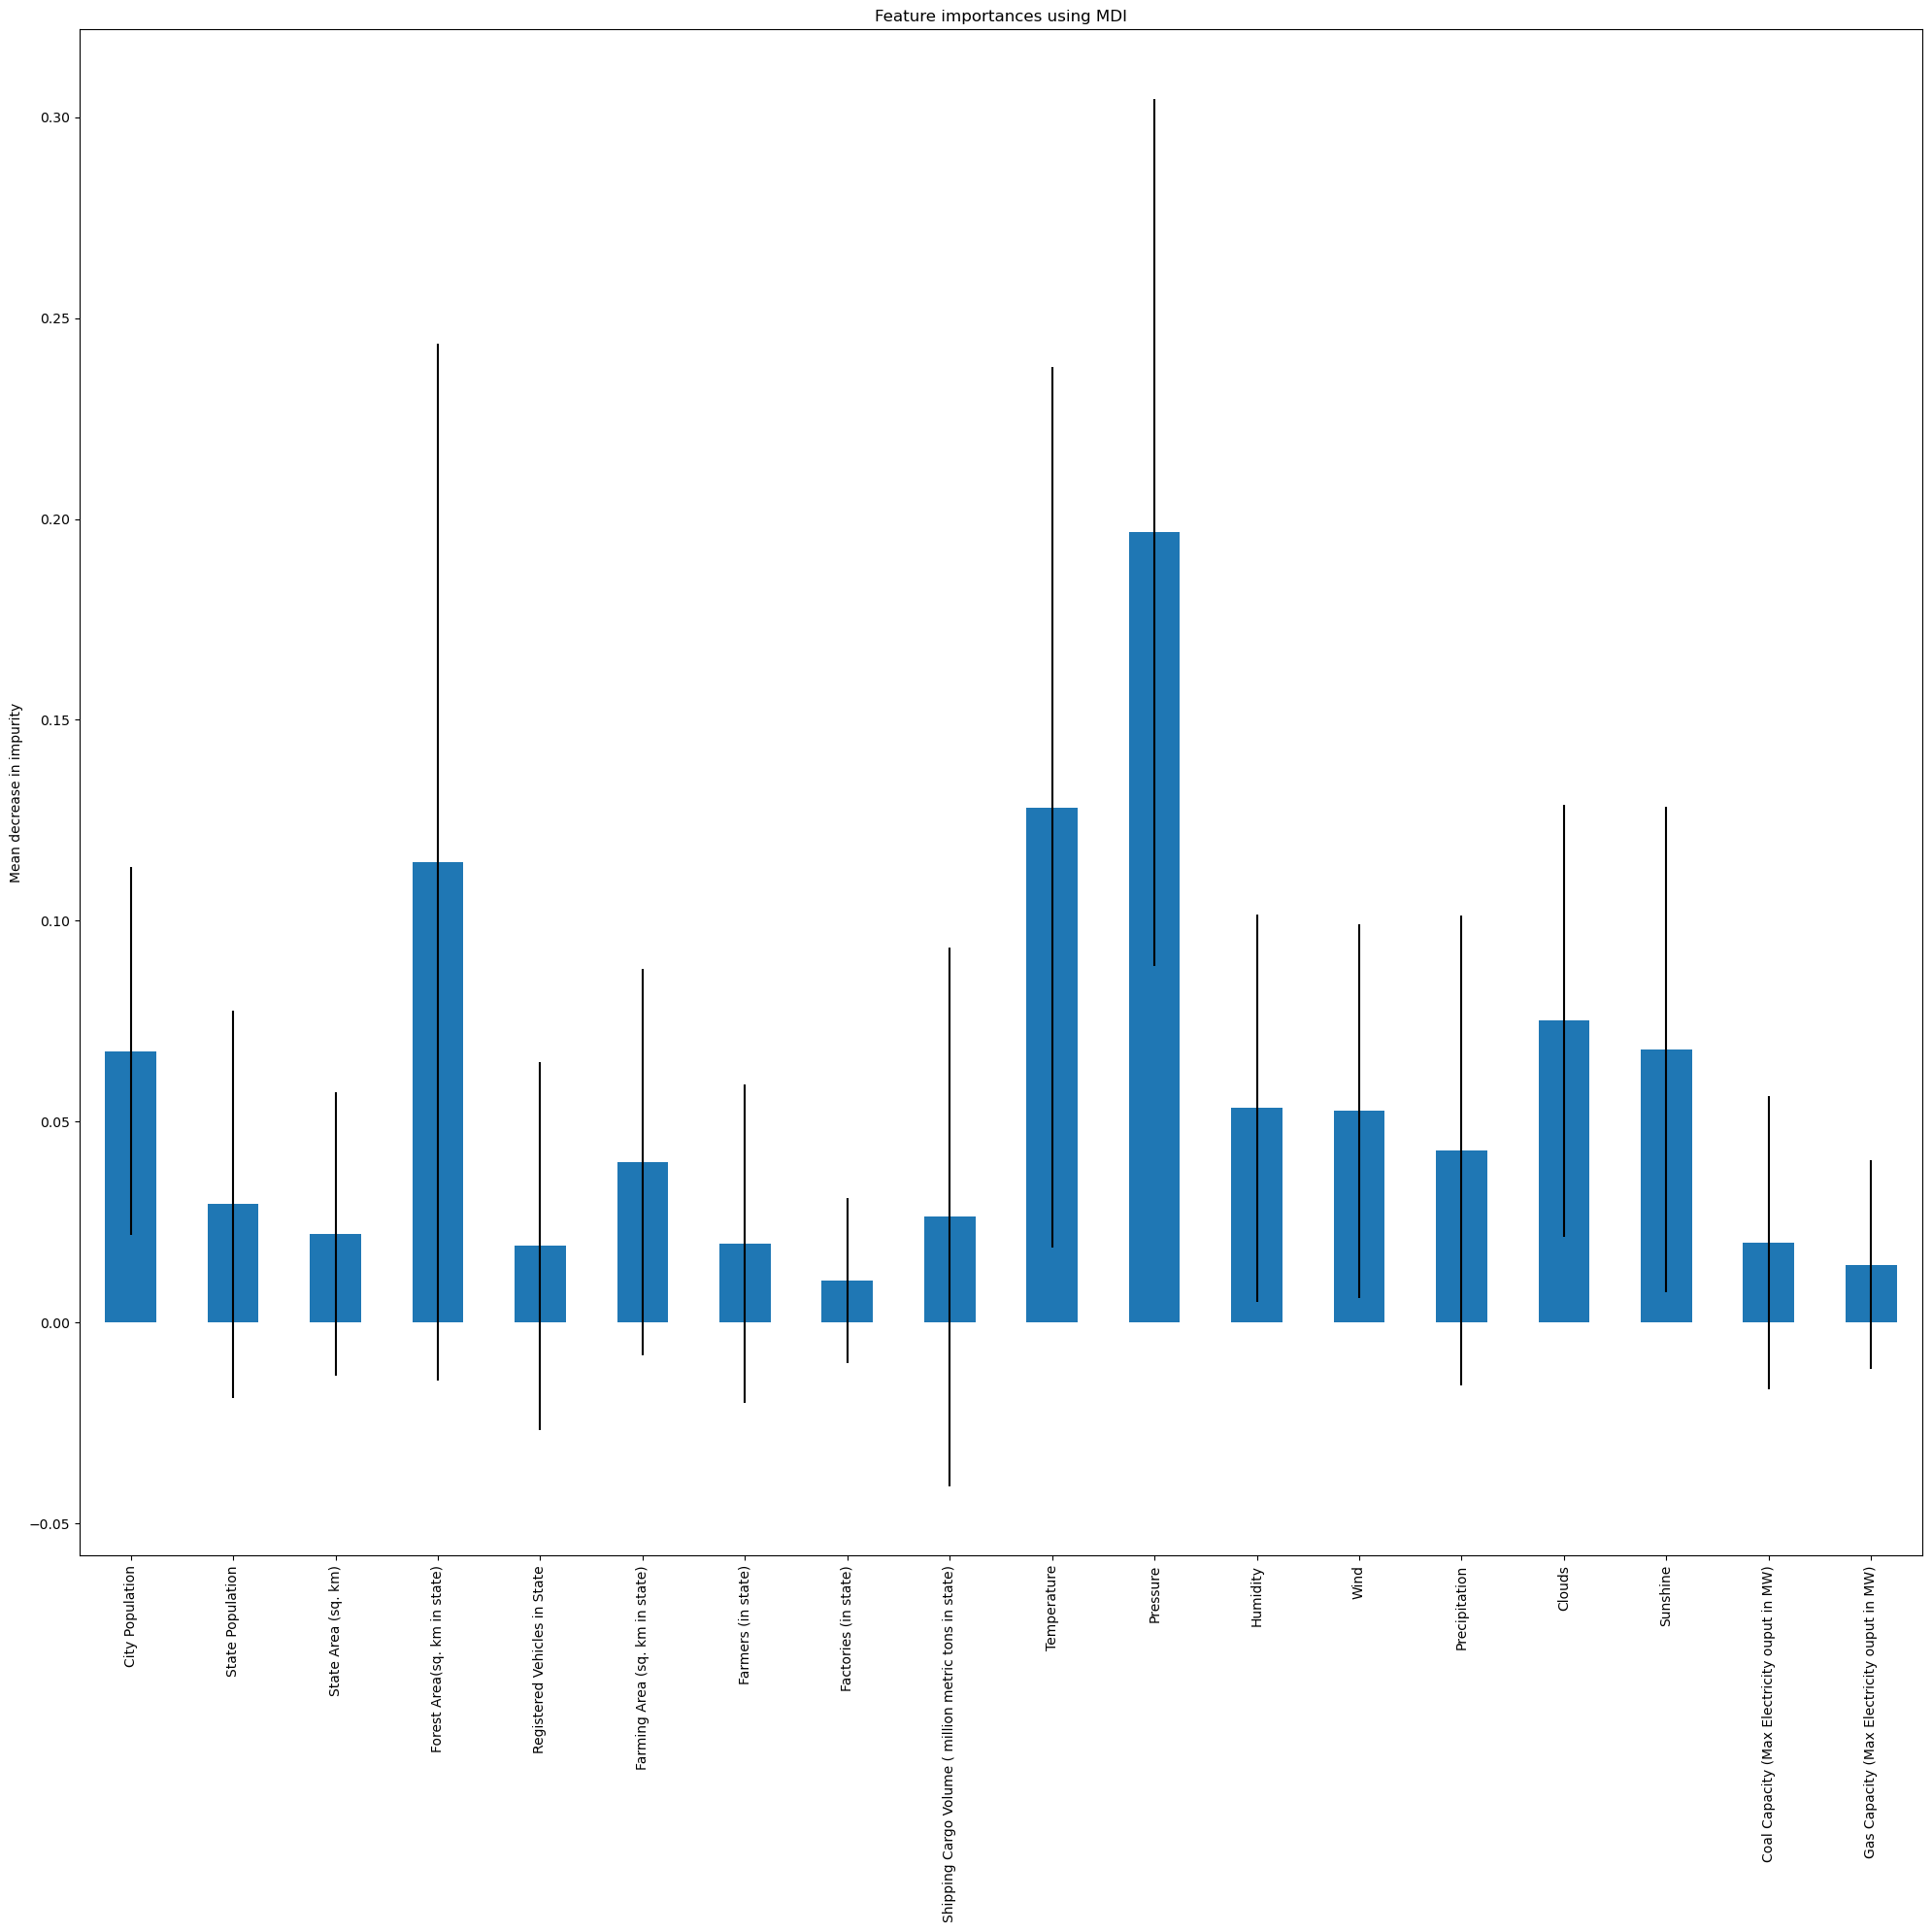

In [58]:
forest_importances = pd.Series(importances, index=x_names)

fig, ax = plt.subplots(figsize=(20,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Geographical plot:

In [82]:
df = pd.read_csv("DATA_INDIA/weather/jan_2024_weather_all_states.csv")

In [88]:
df

,Unnamed: 0,City,Temperature,Pressure,Humidity,Wind,Precipitation,Clouds,Sunshine,Latitude,Longitude
0,0,naharlagun,288.90,1011.15,71.49,1.42,0.02,32.07,98.92,27.103045,93.692392
1,1,srinagar,271.44,911.92,70.46,0.96,0.01,45.45,115.46,34.074744,74.820444
2,2,chittoor,295.67,1001.66,74.45,2.29,0.02,36.89,127.38,13.216122,79.097282
3,3,kadapa,296.25,1003.44,71.12,2.44,0.01,29.62,120.38,14.475294,78.821686
4,4,anantapur,296.60,991.11,60.54,3.30,0.01,30.48,168.92,14.678322,77.606504
...,...,...,...,...,...,...,...,...,...,...,...
258,258,gaya,288.42,1013.79,71.25,2.13,0.07,28.07,163.69,24.796436,85.007956
259,259,dhanbad,290.48,1007.18,57.16,2.32,0.02,17.99,225.08,23.795281,86.430964
260,260,jorapokhar,290.48,1007.18,57.16,2.32,0.02,17.99,225.08,23.716707,86.411017
261,261,pathardih,290.48,1007.18,57.16,2.32,0.02,17.99,225.08,23.675342,86.428285


In [90]:
df.Temperature = df.Temperature - 273.15

In [91]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326"
)



In [92]:
gdf.explore(column="Temperature",  
    scheme="FisherJenks",  
    legend=True,  
    k=6,
    cmap = "OrRd",
           )

/opt/anaconda3/envs/m_data/lib/python3.12/site-packages/geopandas/explore.py:492: UserWarning: Numba not installed. Using slow pure python version.
  binning = classify(


In [69]:
#ax = world.clip([70, 100, 6, 36]).plot(color="white", edgecolor="black")


### Coal and gas data:

We webscraped data from a Wikipedia page. It contained the power of different power plants in different states in India. 
We clean the data and aggregate it at a state level. This is imperfect as the impact of a power plant on the AQI will probably be concentrated geographically close to the power plant. It may also be possible that the plant is not operating at full capacity. There were some states without any power plants. Since the website seemed pretty well maintained, for those states we assume that there is no coal or gas plants respectively.

A possible extension would have been to use the coordinates of the power plants (Wikipedia had some of them) and constructed some measure of distance to the nearest cities.

## AQI Data
To obtain the AQI data we found this repository: https://airquality.cpcb.gov.in/ccr/#/caaqm-dashboard-all/caaqm-landing/aqi-repository
It is from the central pollution control board, and this particular website is a bit hard to find.

You can select the data for a given city at the daily level for a given year. Then you have to click and do this for all the 280 cities available. There are capchas so a robot is a difficult option.
The data is pretty well formatted and you can loop over it to create a full dataframe, this is what is done in the following code.
In summary it loops through a working directory where all the states are. So the loop is for each state and within a state each city.
The functions transform the data from wide format (one column for each month) to long format with one long column and an attribute for it being in a given month. The other function is just to get the name of the city. The name of the city often does not appear in the excel file, it just appears in the name of the file, so we must obtain it from there.

## City level modelling and explanation.

At a city level we have more observations. Unfortunately India hasn't conducted an official census sine 2010 so the population data was not easy to find. We drop the 100 cities and conduct our analysis. We  


### Lasso at city level

### Random forest at city level


Limitations: looking at the map it does look while some cities are (relatively) small in population, they are very close to Dehli or some other mega city. It can be seen very clearly in the interactive AQI map at the city level. Therefore some factors from the neighbors seem to be affecting our observations. This breaks down the traditional iid assumption.  A good approach would have been to control for promixity to other cities in the sample or some other geographic/network measure. Block bootstrap would have also been needed in the event we had a better dataset.

Using other months in the year we could have also used fixed effects to control for these unobserved constants that remain constant in cities over time.

- Random forest can actually handle missing data so we could have done our analysis with 100 extra cities. We didn't know if it was straightforward and wanted a sample on which we could run different models so we could compare their outputs. But it could still be done, it is left to future research.


## Dataframe:

We drop the registered vehicles in a city,we only have 30 observations which is not enough for models that can't handle missing values.
We haven't got population data for 130 cities. It turns out it is does not seem to be correlated with the AQI as can be seen in the first plot below. We can then more or less claim we have a random sample. And that our results are applicable to the original sample.
We then drop cities with missing population for models that can't handle missing values. This leaves us with 136 cities for our final city level analysis.

Why is it important to do some analysis at a city level? As you can see in the final plot in this section, there are large differences in AQI across different states. For some states, like Bihar, the differences range from 150 to 350 AQI, that is from acceptable AQI to very unhealthy AQI. For some other states, like Karnataka, the differences are really small, which could mean that aggregating at a state level is not too bad. However the AQI for those cities may all be low but their characteristics different, then the fact that they have similar  AQI would prove very informative. 
